In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess

def normalize_model_class_name(model_class_name):
    line1 = model_class_name
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretClassifier_" , "caret.classifier.caret_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretRegressor_" , "caret.regressor.caret_reg_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor_" , "caret.preprocessor.caret_prep_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasClassifier_" , "keras.classifier.keras_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasRegressor_" , "keras.regressor.keras_reg_")
    return line1

def normalize_model_name(model_name):
    line1 = model_name
    line1 = line1.replace("cCaretClassifier_" , "caret_class_")
    line1 = line1.replace("cCaretRegressor_" , "caret_reg_")
    line1 = line1.replace("cCaretPreprocessor_" , "caret_prep_")
    line1 = line1.replace("cKerasClassifier_" , "keras_class_")
    line1 = line1.replace("cKerasRegressor_" , "keras_reg_")
    return line1

database_name_from_dsn = {"pgsql" : "PostgreSQL",
                          "oracle" : "Oracle", 
                          "db2" : "IBM DB2", 
                          "sqltm" : "SQLite",
                          "mssql" : "MS SQL Server",
                          "mysql" : "MariaDB",
                          "hive" : "Apache Hive",
                          "impala" : "Impala",
                          "firebird" : "Firebird",
                          "monetdb" : "MonetDB",
                          "teradata" : "Teradata"}

def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

def truncate_error_message(x):
    lSpecialErrors = ['UnboundLocalError', 
                      'Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS', 
                      'Exception:CODE_GENERATION_NOT_IMPLEMENTED_FOR_MODEL',
                      'cTrainingError:Exception:TRAIN_FAILED', 
                      'Exception:CHECK_MATERIALIZED_DATA_ERROR', 
                      'Exception:PREDICT_FAILED', 
                      'NAN_VALUE_ENCOUNTERED_IN_MODEL', 
                      'Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTED', 
                      'Exception:CONNECTION_FAILED_WITH_ERROR',
                      'FileNotFoundError', 'IndexError', 'KeyError', 
                      'DBAPIError:(impala.error.HiveServer2Error) AnalysisException: Invalid column/field name:', 
                      'cTrainingError']
    for lError in lSpecialErrors:
        if(lError in x):
            return lError + " ..."
    lLongMessages = ["concurrent transaction number is", 
                     "DOUBLE value is out of range in",
                     "Unexpected end of command" , 
                     "Token unknown"]
    for mess in lLongMessages:
        x = re.sub(mess + ".*$", mess + " ...", x) 
     
    x = re.sub("\(Background on this error at:.*\)", "", x) 
    x = re.sub("\[SQL.*$", "\[SQL ...", x) 
    return x[0:400]

def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = re.sub('^.*log:BENCH_STATUS ' , '',  line)
        # print(line1)
        fields = line1.split(" ")
        (lModel, lDatasetName, lDSN, lDialect, lDSNType) = fields[0:5]
        lStatus = " ".join(fields[5:-1])
        lTime = fields[-1][:-2]
        fields2 = lStatus.split(" ")
        lErrorMessage = " ".join(fields2[5:])
        status = fields2[4]

        sql_error = lErrorMessage
        
        
        row = [lModel, lDatasetName, lDialect, lDSN, status, lErrorMessage, lTime]
        if(False):
            print("[lModel]" , row[0])
            print("[lDatasetName]" , row[1])
            print("[lDialect]" , row[2])
            print("[lDSN]" , row[3])
            print("[status]" , row[4])
            print("[lErrorMessage]" , row[5])
            print("[lTime]" , row[6])
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['dialect'] = df['dialect'].apply(lambda x : strip_punc(x))
    df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
    df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
    df['status'] = df['status'].apply(lambda x : strip_punc(x))

    print(list( df['dialect'].unique()))
    df['dialect'] = df['dialect'].apply(database_name_from_dsn.get)
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['Model'] = df['Model'].apply(normalize_model_name)
    df['full_error_message'] = df['error_message']
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    df['error_message'] = df['error_message'].apply(truncate_error_message)
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

['db2', 'firebird', 'impala', 'monetdb', 'mssql', 'mysql', 'oracle', 'pgsql', 'sqltm', 'teradata']


In [5]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message
0,LGBMClassifier,DS_BENCH_C_50_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),"
1,LGBMClassifier,DS_BENCH_C_50_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),"
2,LGBMClassifier_pipe,p_DS_BENCH_C_50_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),"
3,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),"
4,LGBMClassifier_pipe,p_DS_BENCH_C_50_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),"


In [6]:
df.Model.value_counts()

LabelBinarizer                      180
keras_class_LSTM                    180
LabelEncoder                        180
keras_class_SimpleRNN_pipe          180
PassiveAggressiveClassifier_pipe    180
DummyClassifier_pipe                180
ExtraTreeClassifier                 180
BaggingClassifier_pipe              180
ExtraTreesClassifier_pipe           180
DummyClassifier                     180
DecisionTreeClassifier              180
keras_class_LSTM_pipe               180
RandomForestClassifier              180
LinearSVC_pipe                      180
RidgeClassifier_pipe                180
ExtraTreeClassifier_pipe            180
DecisionTreeClassifier_pipe         180
BaggingClassifier                   180
LinearSVC                           180
PassiveAggressiveClassifier         180
SGDClassifier_pipe                  180
keras_class_GRU                     180
ExtraTreesClassifier                180
RandomForestClassifier_pipe         180
keras_class_SimpleRNN               180


In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        line1 = normalize_model_class_name(line1)
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'LGBMClassifier': 'lightgbm.sklearn.LGBMClassifier',
 'LGBMRegressor': 'lightgbm.sklearn.LGBMRegressor',
 'caret_class_ctree': 'caret.classifier.caret_class_ctree',
 'caret_class_ctree2': 'caret.classifier.caret_class_ctree2',
 'caret_class_earth': 'caret.classifier.caret_class_earth',
 'caret_class_glm': 'caret.classifier.caret_class_glm',
 'caret_class_glmnet': 'caret.classifier.caret_class_glmnet',
 'caret_class_nnet': 'caret.classifier.caret_class_nnet',
 'caret_class_rf': 'caret.classifier.caret_class_rf',
 'caret_class_rpart': 'caret.classifier.caret_class_rpart',
 'caret_class_svmLinear': 'caret.classifier.caret_class_svmLinear',
 'caret_class_svmPoly': 'caret.classifier.caret_class_svmPoly',
 'caret_class_svmRadial': 'caret.classifier.caret_class_svmRadial',
 'caret_class_svmRadialCost': 'caret.classifier.caret_class_svmRadialCost',
 'caret_class_svmRadialSigma': 'caret.classifier.caret_class_svmRadialSigma',
 'caret_class_svmRadialWeights': 'caret.classifier.caret_class_svmRa

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category
0,LGBMClassifier,DS_BENCH_C_50_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
1,LGBMClassifier,DS_BENCH_C_50_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
2,LGBMClassifier_pipe,p_DS_BENCH_C_50_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
3,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
4,LGBMClassifier_pipe,p_DS_BENCH_C_50_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, 'TIMEOUT', get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

['IBM DB2' 'Firebird' 'Impala' 'MonetDB' 'MS SQL Server' 'MariaDB'
 'Oracle' 'PostgreSQL' 'SQLite' 'Teradata']
df.shape (27230, 9) Index(['Model', 'dataset', 'dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'full_error_message', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING IBM DB2 caret_class_ctree2 18 9
MODEL_DATASETS_MISSING IBM DB2 caret_class_ctree2_pipe 18 9
MODEL_DATASETS_MISSING IBM DB2 caret_class_svmPoly_pipe 12 6
MODEL_DATASETS_MISSING Firebird caret_class_ctree_pipe 18 10
MODEL_DATASETS_MISSING Firebird caret_class_earth 18 9
MODEL_DATASETS_MISSING Firebird caret_class_earth_pipe 18 10
MODEL_DATASETS_MISSING Firebird caret_class_nnet_pipe 18 9
MODEL_DATASETS_MISSING Firebird caret_class_rf_pipe 18 9
MODEL_DATASETS_MISSING Firebird caret_class_rpart_pipe 18 10
MODEL_DATASETS_MISSING Firebird caret_class_svmPoly 12 6
MODEL_DATASETS_MISSING Firebird caret_class_svmPoly_pipe 12 8
MODEL_DATASETS_MISSING Firebird caret_class_svmRadial_pipe 18 

In [15]:
missing_data.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category
0,SVC,DS_BENCH_C_200_82_10_EA8E6ACF,IBM DB2,no_dsn,failure,TIMEOUT,None,TIMEOUT,sklearn.svm
1,caret_class_ctree2,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,no_dsn,failure,TIMEOUT,None,TIMEOUT,caret.classifier
2,caret_class_ctree2,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,no_dsn,failure,TIMEOUT,None,TIMEOUT,caret.classifier
3,caret_class_ctree2,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,no_dsn,failure,TIMEOUT,None,TIMEOUT,caret.classifier
4,caret_class_ctree2,DS_BENCH_C_200_82_10_EA8E6ACF,IBM DB2,no_dsn,failure,TIMEOUT,None,TIMEOUT,caret.classifier


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category


In [18]:
df.shape

(28910, 9)

In [19]:
df.dialect.value_counts()

MonetDB          2891
Impala           2891
IBM DB2          2891
Firebird         2891
MS SQL Server    2891
Teradata         2891
SQLite           2891
PostgreSQL       2891
MariaDB          2891
Oracle           2891
Name: dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['dialect'])['error_message'].value_counts())

In [22]:
df4 = msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)
df4.head(df4.shape[0])

/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'error_message' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,,error_message
dialect,error_message,
Impala,TIMEOUT,587
MonetDB,TIMEOUT,391
PostgreSQL,Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...,254
IBM DB2,Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...,254
MS SQL Server,Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...,244
Firebird,"""DatabaseError:('Error while commiting transaction:\\n- SQLCODE: -913\\n- deadlock\\n- update conflicts with concurrent update\\n- concurrent transaction number is ...",244
MariaDB,Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...,240
Oracle,Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...,239
Teradata,Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...,232


In [23]:
sorted(df.error_message.unique().tolist())

['"DBAPIError:(impala.error.HiveServer2Error) AnalysisException: Exceeded the maximum depth of an expression tree (1000).\\n \\[SQL ...',
 '"DatabaseError:(\'Error while commiting transaction:\\\\n- SQLCODE: -913\\\\n- deadlock\\\\n- update conflicts with concurrent update\\\\n- concurrent transaction number is ...',
 '"DatabaseError:(fdb.fbcore.DatabaseError) (\'Cursor.fetchone:\\\\n- SQLCODE: -802\\\\n- arithmetic exception, numeric overflow, or string truncation\\\\n- numeric value is out of range\', -802, 335544321) ,',
 '"DatabaseError:(fdb.fbcore.DatabaseError) (\'Cursor.fetchone:\\\\n- SQLCODE: -901\\\\n- Integer overflow.  The result of an integer operation caused the most significant bit of the result to carry.\', -901, 335544779) ,',
 '"DatabaseError:(teradata.api.DatabaseError) (10670, \'[07009] [Teradata][ODBC] (10670) Invalid descriptor index, descriptor record does not exist, or descriptor record was not properly initialized.\') ,',
 '"OperationalError:(impala.error.Opera

In [24]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,23280
Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...,1987
TIMEOUT,1680
Exception:CODE_GENERATION_NOT_IMPLEMENTED_FOR_MODEL ...,358
Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTED ...,283
"""DatabaseError:('Error while commiting transaction:\\n- SQLCODE: -913\\n- deadlock\\n- update conflicts with concurrent update\\n- concurrent transaction number is ...",244
"'DatabaseError:(teradata.api.DatabaseError) (3754, \'[HY000] [Teradata][ODBC Teradata Driver][Teradata Database](-3754)Precision error in FLOAT type constant or during implicit conversions.\') \[SQL ...",160
'DatabaseError:(fdb.fbcore.DatabaseError) (\'Error while preparing SQL statement:\\n- SQLCODE: -104\\n- Dynamic SQL Error\\n- SQL error code = -104\\n- Unexpected end of command ...,131
DBAPIError:(impala.error.HiveServer2Error) AnalysisException: Invalid column/field name: ...,118
"'DatabaseError:(fdb.fbcore.DatabaseError) (\'Error while preparing SQL statement:\\n- SQLCODE: -902\\n- Dynamic SQL Error\\n- Too many Contexts of Relation/Procedure/Views. Maximum allowed is 256\', -902, 335544569) \[SQL ...",103


In [25]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [26]:
#lGroupBy['rows'].describe()

In [27]:
lComparisonErrorMessage = '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS'
real_errors = df[df.error_message.str.contains(lComparisonErrorMessage)]
real_errors.Model.value_counts()

Series([], Name: Model, dtype: int64)

In [28]:
lNotImplementedMessage = 'CODE_GENERATION_NOT_IMPLEMENTED_FOR_MODEL'

not_impl_errors = df[df.error_message.str.contains(lNotImplementedMessage)]
not_impl_errors.Model.value_counts()


MiniBatchSparsePCA           120
SparsePCA                    118
LatentDirichletAllocation     60
NMF                           60
Name: Model, dtype: int64

In [29]:
# database related errors
def is_other_error(x):
    lKnownError = 'SUCCESS' in [x] or lComparisonErrorMessage in [x] or lNotImplementedMessage in [x]
    return not lKnownError

# other_errors = df.error_message.apply(lambda x : 1 if is_other_error(x)  else 0)
other_errors = df[df.error_message.apply(is_other_error)]
other_errors.Model.value_counts()


caret_class_svmRadialSigma           180
caret_class_svmRadialWeights_pipe    180
caret_class_svmRadialWeights         180
caret_class_svmLinear_pipe           180
caret_class_svmRadialCost            180
caret_class_svmLinear                180
caret_class_svmRadialSigma_pipe      180
caret_class_svmRadialCost_pipe       180
caret_class_svmRadial_pipe           159
caret_class_svmRadial                128
caret_class_svmPoly_pipe             120
caret_class_svmPoly                  120
MiniBatchSparsePCA                   120
SparsePCA                            120
caret_class_nnet_pipe                 98
caret_class_xgbTree_pipe              97
caret_class_nnet                      96
keras_class_SimpleRNN_pipe            95
caret_class_xgbTree                   92
keras_class_SimpleRNN                 85
caret_class_glmnet_pipe               78
caret_class_rf_pipe                   75
keras_class_LSTM_pipe                 75
keras_class_LSTM                      73
caret_class_eart

In [30]:
# df.pivot(index = 'Model', values='status' , columns='dialect')

In [31]:
df.columns

Index(['Model', 'dataset', 'dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'full_error_message', 'model_category'],
      dtype='object')

In [32]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category
0,LGBMClassifier,DS_BENCH_C_50_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
1,LGBMClassifier,DS_BENCH_C_50_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
2,LGBMClassifier_pipe,p_DS_BENCH_C_50_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
3,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
4,LGBMClassifier_pipe,p_DS_BENCH_C_50_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn


In [33]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [34]:

df = df[df['model_category'] != 'sklearn.dummy']
df = df[~df['error_message'].str.contains(lNotImplementedMessage)]



In [35]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category,status_2
0,LGBMClassifier,DS_BENCH_C_50_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,3,"None),",lightgbm.sklearn,1
1,LGBMClassifier,DS_BENCH_C_50_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,3,"None),",lightgbm.sklearn,1
2,LGBMClassifier_pipe,p_DS_BENCH_C_50_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,3,"None),",lightgbm.sklearn,1
3,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,3,"None),",lightgbm.sklearn,1
4,LGBMClassifier_pipe,p_DS_BENCH_C_50_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,3,"None),",lightgbm.sklearn,1


In [36]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                       \
dialect                       Firebird IBM DB2 Impala MS SQL Server MariaDB   
model_category                                                                
caret.classifier                   503     503    503           503     503   
caret.preprocessor                  36      36     36            36      36   
caret.regressor                    168     168    168           168     168   
keras.classifier                   144     144    144           144     144   
keras.regressor                     48      48     48            48      48   
lightgbm.sklearn                    48      48     48            48      48   
sklearn.calibration                 36      36     36            36      36   
sklearn.covariance                  12      12     12            12      12   
sklearn.decomposition               72      72     72            72      72   
sklearn.discriminant_analysis       36      36     36            36      36   
sklearn.ensemble                   252     252    252           252     252   
sklearn.feature_selection          108     108    108           108     108   
sklearn.impute                      24      24     24            24      24   
sklearn.kernel_ridge                12      12     12            12      12   
sklearn.linear_model               492     492    492           492     492   
sklearn.multiclass                  72      72     72            72      72   
sklearn.naive_bayes                144     144    144           144     144   
sklearn.neural_network              48      48     48            48      48   
sklearn.pipeline                    48      48     48            48      48   
sklearn.preprocessing              180     180    180           180     180   
sklearn.random_projection           24      24     24            24      24   
sklearn.svm                        156     156    156           156     156   
sklearn.tree                        96      96     96            96      96   
xgboost.sklearn                     48      48     48            48      48   
All                               2807    2807   2807          2807    2807   

                                                                                
dialect                       MonetDB Oracle PostgreSQL SQLite Teradata    All  
model_category                                                                  
caret.classifier                  503    503        503    503      503   5030  
caret.preprocessor                 36     36         36     36       36    360  
caret.regressor                   168    168        168    168      168   1680  
keras.classifier                  144    144        144    144      144   1440  
keras.regressor                    48     48         48     48       48    480  
lightgbm.sklearn                   48     48         48     48       48    480  
sklearn.calibration                36     36         36     36       36    360  
sklearn.covariance                 12     12         12     12       12    120  
sklearn.decomposition              72     72         72     72       74    722  
sklearn.discriminant_analysis      36     36         36     36       36    360  
sklearn.ensemble                  252    252        252    252      252   2520  
sklearn.feature_selection         108    108        108    108      108   1080  
sklearn.impute                     24     24         24     24       24    240  
sklearn.kernel_ridge               12     12         12     12       12    120  
sklearn.linear_model              492    492        492    492      492   4920  
sklearn.multiclass                 72     72         72     72       72    720  
sklearn.naive_bayes               144    144        144    144      144   1440  
sklearn.neural_network             48     48         48     48       48    480  
sklearn.pipeline                   48     48         48     48       48    480  
sklearn.preprocessing             180   

In [37]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [38]:
pvt.head(pvt.shape[0])

mean                                    \
dialect                        Firebird   IBM DB2    Impala MS SQL Server   
model_category                                                              
caret.classifier               0.759443  0.495030  0.691849      0.560636   
caret.preprocessor             0.111111  0.027778  0.000000      0.000000   
caret.regressor                0.369048  0.011905  0.023810      0.047619   
keras.classifier               0.291667  0.097222  0.791667      0.222222   
keras.regressor                0.166667  0.062500  0.750000      0.062500   
lightgbm.sklearn               0.666667  0.020833  0.625000      0.000000   
sklearn.calibration            0.138889  0.000000  0.611111      0.000000   
sklearn.covariance             0.166667  0.166667  0.166667      0.166667   
sklearn.decomposition          0.222222  0.041667  0.194444      0.027778   
sklearn.discriminant_analysis  0.111111  0.055556  0.777778      0.027778   
sklearn.ensemble               0.500000  0.011905  0.361111      0.007937   
sklearn.feature_selection      0.000000  0.000000  0.000000      0.000000   
sklearn.impute                 0.000000  0.000000  0.000000      0.000000   
sklearn.kernel_ridge           0.750000  0.000000  0.000000      0.000000   
sklearn.linear_model           0.032520  0.002033  0.111789      0.004065   
sklearn.multiclass             0.458333  0.000000  0.500000      0.013889   
sklearn.naive_bayes            0.395833  0.041667  0.652778      0.027778   
sklearn.neural_network         0.354167  0.000000  0.479167      0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000      0.000000   
sklearn.preprocessing          0.111111  0.088889  0.033333      0.033333   
sklearn.random_projection      0.166667  0.000000  0.000000      0.000000   
sklearn.svm                    0.538462  0.019231  0.282051      0.006410   
sklearn.tree                   0.020833  0.000000  0.000000      0.000000   
xgboost.sklearn                0.645833  0.020833  0.645833      0.020833   
All                            0.340577  0.109369  0.348415      0.123620   

                                                                        \
dialect                         MariaDB   MonetDB    Oracle PostgreSQL   
model_category                                                           
caret.classifier               0.481113  0.755467  0.485089   0.461233   
caret.preprocessor             0.000000  0.000000  0.000000   0.083333   
caret.regressor                0.011905  0.000000  0.011905   0.029762   
keras.classifier               0.236111  0.750000  0.097222   0.243056   
keras.regressor                0.020833  0.750000  0.062500   0.062500   
lightgbm.sklearn               0.020833  0.416667  0.020833   0.000000   
sklearn.calibration            0.000000  0.000000  0.000000   0.000000   
sklearn.covariance             0.166667  0.166667  0.166667   0.166667   
sklearn.decomposition          0.027778  0.194444  0.027778   0.027778   
sklearn.discriminant_analysis  0.055556  0.055556  0.055556   0.027778   
sklearn.ensemble               0.007937  0.091270  0.007937   0.007937   
sklearn.feature_selection      0.000000  0.000000  0.000000   0.000000   
sklearn.impute                 0.000000  0.000000  0.000000   0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000   0.000000   
sklearn.linear_model           0.002033  0.002033  0.002033   0.002033   
sklearn.multiclass             0.000000  0.000000  0.000000   0.000000   
sklearn.naive_bayes            0.027778  0.472222  0.027778   0.027778   
sklearn.neural_network         0.000000  0.333333  0.000000   0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000   0.000000   
sklearn.preprocessing          0.033333  0.094444  0.033333   0.022222   
sklearn.random_projection      0.000000  0.000000  0.000000   0.000000   
sklearn.svm                    0.000000  0.076923  0.217949   0.000000   
sklearn.tree                

In [39]:
df.to_csv('report_extensive_tests.csv')

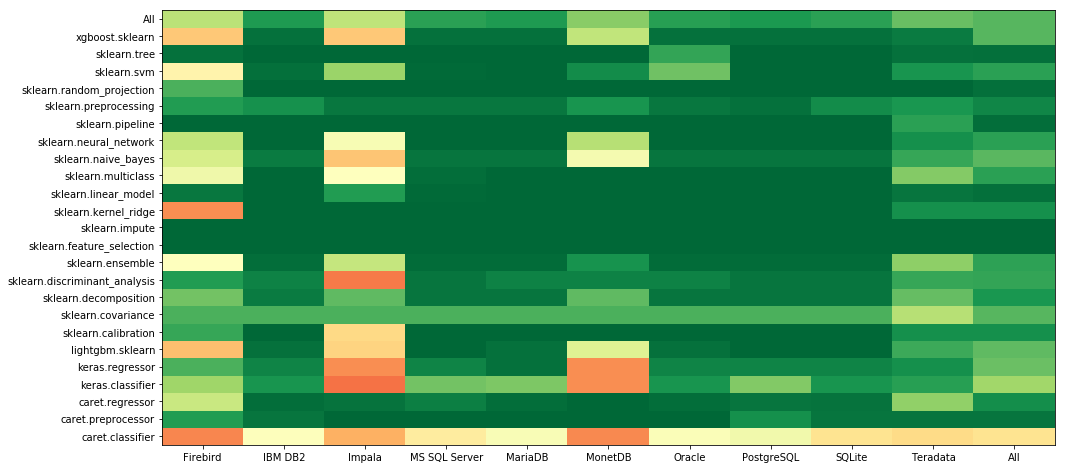

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn' , vmin=0 , vmax=1)
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [41]:
Category_Labels = df.model_category.unique()


In [42]:
Category_Labels

array(['lightgbm.sklearn', 'caret.classifier', 'caret.preprocessor',
       'caret.regressor', 'keras.classifier', 'keras.regressor',
       'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection', 'sklearn.impute',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.random_projection',
       'sklearn.svm', 'sklearn.tree', 'xgboost.sklearn'], dtype=object)

In [43]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
dialect       error_message                                                    
Firebird      "DatabaseError:('Error while commiting transact...             27
              SUCCESS                                                        16
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              5
IBM DB2       SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Impala        TIMEOUT                                                        22
              SUCCESS                                                        18
              DBAPIError:(impala.error.HiveServer2Error) Anal...              8
MS SQL Server SUCCESS                                                        48
MariaDB       SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
MonetDB       SUCCESS                                                        28
              TIMEOUT                                                        16
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              4
Oracle        SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
PostgreSQL    SUCCESS                                                        48
SQLite        SUCCESS                                                        48
Teradata      SUCCESS                                                        41
              'DatabaseError:(teradata.api.DatabaseError) (26...              5
              'DatabaseError:(teradata.api.DatabaseError) (37...              1
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1

mean                                              \
dialect              Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                       
LGBMClassifier       0.833333  0.000000  0.833333           0.0  0.000000   
LGBMClassifier_pipe  0.611111  0.055556  0.833333           0.0  0.055556   
LGBMRegressor        0.500000  0.000000  0.000000           0.0  0.000000   
LGBMRegressor_pipe   0.500000  0.000000  0.000000           0.0  0.000000   
All                  0.666667  0.020833  0.625000           0.0  0.020833   

                                                                               
dialect               MonetDB    Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                          
LGBMClassifier       0.555556  0.000000        0.0    0.0  0.166667  0.238889  
LGBMClassifier_pipe  0.555556  0.055556        0.0    0.0  0.166667  0.233333  
LGBMRegressor        0.000000  0.000000        0.0    0.0  0.000000  0.050000  
LGBMRegressor_pipe   0.000000  0.000000        0.0    0.0  0.166667  0.066667  
All                  0.416667  0.020833        0.0    0.0  0.145833  0.191667

ERROR_REPORT_FOR_CATEGORY caret.classifier


error_message
dialect       error_message                                                    
Firebird      TIMEOUT                                                       216
              SUCCESS                                                       121
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                59
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             35
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             32
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...             20
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             13
              cTrainingError:Exception:TRAIN_FAILED ...                       4
              "DatabaseError:('Error while commiting transact...              3
IBM DB2       SUCCESS                                                       254
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...               207
              TIMEOUT                                                        32
              cTrainingError:Exception:TRAIN_FAILED ...                       6
              FileNotFoundError ...                                           2
              IndexError ...                                                  2
Impala        TIMEOUT                                                       241
              SUCCESS                                                       155
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                78
              DBAPIError:(impala.error.HiveServer2Error) Anal...             16
              cTrainingError:Exception:TRAIN_FAILED ...                      13
MS SQL Server SUCCESS                                                       221
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...               210
              TIMEOUT                                                        40
              "OperationalError:(pymssql.OperationalError) (1...             15
              cTrainingError:Exception:TRAIN_FAILED ...                      12
              'OperationalError:(pymssql.OperationalError) (7...              2
              FileNotFoundError ...                                           2
              "OperationalError:(pymssql.OperationalError) (2...              1
MariaDB       SUCCESS                                                       261
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...               197
...                                                                         ...
              FileNotFoundError ...                                           1
MonetDB       TIMEOUT                                                       266
              SUCCESS                                                       123
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...               111
              cTrainingError:Exception:TRAIN_FAILED ...                       2
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              1
Oracle        SUCCESS                                                       259
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...               183
              TIMEOUT                                                        56
              'ValueError:Length mismatch: Expected axis has ...              2
              'ValueError:Length mismatch: Expected axis has ...              1
              FileNotFoundError ...                                           1
              IndexError ...                                                  1
PostgreSQL    SUCCESS                                                       271
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...               219
              cTrainingError:Exception:TRAIN_FAILED ...                       9
              TIMEOUT                                                         3
              FileNotFoundError ...                               

mean                                    \
dialect                            Firebird   IBM DB2    Impala MS SQL Server   
Model                                                                           
caret_class_ctree                  0.444444  0.000000  0.000000      0.000000   
caret_class_ctree2                 0.388889  0.500000  0.000000      0.500000   
caret_class_ctree2_pipe            0.444444  0.500000  0.333333      1.000000   
caret_class_ctree_pipe             0.555556  0.000000  0.055556      0.000000   
caret_class_earth                  0.611111  0.166667  0.777778      0.333333   
caret_class_earth_pipe             0.611111  0.166667  0.777778      0.277778   
caret_class_glm                    0.000000  0.000000  0.500000      0.166667   
caret_class_glm_pipe               0.500000  0.333333  0.500000      0.333333   
caret_class_glmnet                 0.555556  0.000000  0.722222      0.166667   
caret_class_glmnet_pipe            0.722222  0.166667  0.833333      0.166667   
caret_class_nnet                   0.833333  0.333333  0.777778      0.333333   
caret_class_nnet_pipe              0.833333  0.333333  0.833333      0.333333   
caret_class_rf                     0.555556  0.000000  0.555556      0.444444   
caret_class_rf_pipe                0.611111  0.111111  0.611111      0.500000   
caret_class_rpart                  0.444444  0.055556  0.000000      0.000000   
caret_class_rpart_pipe             0.555556  0.000000  0.000000      0.000000   
caret_class_svmLinear              1.000000  1.000000  1.000000      1.000000   
caret_class_svmLinear_pipe         1.000000  1.000000  1.000000      1.000000   
caret_class_svmPoly                1.000000  1.000000  1.000000      1.000000   
caret_class_svmPoly_pipe           1.000000  1.000000  1.000000      1.000000   
caret_class_svmRadial              0.941176  0.647059  0.823529      0.705882   
caret_class_svmRadialCost          1.000000  1.000000  1.000000      1.000000   
caret_class_svmRadialCost_pipe     1.000000  1.000000  1.000000      1.000000   
caret_class_svmRadialSigma         1.000000  1.000000  1.000000      1.000000   
caret_class_svmRadialSigma_pipe    1.000000  1.000000  1.000000      1.000000   
caret_class_svmRadialWeights       1.000000  1.000000  1.000000      1.000000   
caret_class_svmRadialWeights_pipe  1.000000  1.000000  1.000000      1.000000   
caret_class_svmRadial_pipe         1.000000  0.777778  0.944444      0.777778   
caret_class_xgbTree                0.833333  0.333333  0.833333      0.333333   
caret_class_xgbTree_pipe           0.833333  0.333333  0.833333      0.333333   
All                                0.759443  0.495030  0.691849      0.560636   

                                                                            \
dialect                             MariaDB   MonetDB    Oracle PostgreSQL   
Model                                                                        
caret_class_ctree                  0.000000  0.388889  0.166667   0.111111   
caret_class_ctree2                 0.000000  0.388889  0.166667   0.000000   
caret_class_ctree2_pipe            0.000000  0.444444  0.111111   0.000000   
caret_class_ctree_pipe             0.055556  0.500000  0.111111   0.000000   
caret_class_earth                  0.222222  0.555556  0.166667   0.166667   
caret_class_earth_pipe             0.277778  0.611111  0.166667   0.166667   
caret_class_glm                    0.000000  0.000000  0.000000   0.000000   
caret_class_glm_pipe               0.333333  0.333333  0.333333   0.333333   
caret_class_glmnet                 0.055556  0.777778  0.000000   0.000000   
caret_class_glmnet_pipe            0.166667  0.888889  0.111111   0.111111   
caret_class_nnet                   0.444444  0.888889  0.333333   0.333333   
caret_class_nnet_pipe              0.388889  0.888889  0.333333   0.333333   
caret_class_rf                     0.000000  0.388889  0.000000   0.000000   
caret_class_rf_pipe                0

ERROR_REPORT_FOR_CATEGORY caret.preprocessor


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        32
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              4
IBM DB2       SUCCESS                                                        35
              Exception:PREDICT_FAILED ...                                    1
Impala        SUCCESS                                                        36
MS SQL Server SUCCESS                                                        36
MariaDB       SUCCESS                                                        36
MonetDB       SUCCESS                                                        36
Oracle        SUCCESS                                                        36
PostgreSQL    SUCCESS                                                        33
              Exception:PREDICT_FAILED ...                                    3
SQLite        SUCCESS                                                        35
              Exception:PREDICT_FAILED ...                                    1
Teradata      SUCCESS                                                        35
              Exception:PREDICT_FAILED ...                                    1

mean                                         \
dialect                  Firebird   IBM DB2 Impala MS SQL Server MariaDB   
Model                                                                      
caret_prep_center_scale  0.000000  0.000000    0.0           0.0     0.0   
caret_prep_ica           0.000000  0.083333    0.0           0.0     0.0   
caret_prep_pca           0.333333  0.000000    0.0           0.0     0.0   
All                      0.111111  0.027778    0.0           0.0     0.0   

                                                                       \
dialect                 MonetDB Oracle PostgreSQL    SQLite  Teradata   
Model                                                                   
caret_prep_center_scale     0.0    0.0   0.250000  0.000000  0.000000   
caret_prep_ica              0.0    0.0   0.000000  0.083333  0.000000   
caret_prep_pca              0.0    0.0   0.000000  0.000000  0.083333   
All                         0.0    0.0   0.083333  0.027778  0.027778   

                                   
dialect                       All  
Model                              
caret_prep_center_scale  0.025000  
caret_prep_ica           0.016667  
caret_prep_pca           0.041667  
All                      0.027778

ERROR_REPORT_FOR_CATEGORY caret.regressor


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       106
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             46
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...             15
              "DatabaseError:('Error while commiting transact...              1
IBM DB2       SUCCESS                                                       166
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
Impala        SUCCESS                                                       164
              cTrainingError:Exception:TRAIN_FAILED ...                       4
MS SQL Server SUCCESS                                                       160
              "OperationalError:(pymssql.OperationalError) (1...              8
MariaDB       SUCCESS                                                       166
              cTrainingError:Exception:TRAIN_FAILED ...                       2
MonetDB       SUCCESS                                                       168
Oracle        SUCCESS                                                       166
              cTrainingError:Exception:TRAIN_FAILED ...                       2
PostgreSQL    SUCCESS                                                       163
              cTrainingError:Exception:TRAIN_FAILED ...                       4
              KeyError ...                                                    1
SQLite        SUCCESS                                                       164
              cTrainingError:Exception:TRAIN_FAILED ...                       2
              'ValueError:Length mismatch: Expected axis has ...              1
              TIMEOUT                                                         1
Teradata      SUCCESS                                                       123
              'DatabaseError:(teradata.api.DatabaseError) (37...             30
              cTrainingError:Exception:TRAIN_FAILED ...                       6
              'DatabaseError:(teradata.api.DatabaseError) (26...              4
              'DatabaseError:(teradata.api.DatabaseError) (37...              3
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2

mean                                    \
dialect                        Firebird   IBM DB2    Impala MS SQL Server   
Model                                                                       
caret_reg_ctree                0.000000  0.000000  0.166667      0.000000   
caret_reg_ctree2               0.000000  0.000000  0.166667      0.000000   
caret_reg_ctree2_pipe          0.333333  0.000000  0.166667      0.000000   
caret_reg_ctree_pipe           0.333333  0.000000  0.166667      0.000000   
caret_reg_earth                0.000000  0.000000  0.000000      0.000000   
caret_reg_earth_pipe           0.333333  0.000000  0.000000      0.000000   
caret_reg_glm                  0.000000  0.000000  0.000000      0.000000   
caret_reg_glm_pipe             0.333333  0.000000  0.000000      0.000000   
caret_reg_glmnet               0.000000  0.000000  0.000000      0.000000   
caret_reg_glmnet_pipe          0.333333  0.000000  0.000000      0.000000   
caret_reg_nnet                 0.000000  0.000000  0.000000      0.000000   
caret_reg_nnet_pipe            0.333333  0.000000  0.000000      0.000000   
caret_reg_rf                   0.000000  0.000000  0.000000      0.500000   
caret_reg_rf_pipe              0.333333  0.000000  0.000000      0.833333   
caret_reg_rpart                0.000000  0.166667  0.000000      0.000000   
caret_reg_rpart_pipe           0.333333  0.166667  0.000000      0.000000   
caret_reg_svmLinear            0.500000  0.000000  0.000000      0.000000   
caret_reg_svmLinear_pipe       0.666667  0.000000  0.000000      0.000000   
caret_reg_svmPoly              0.500000  0.000000  0.000000      0.000000   
caret_reg_svmPoly_pipe         0.833333  0.000000  0.000000      0.000000   
caret_reg_svmRadial            0.833333  0.000000  0.000000      0.000000   
caret_reg_svmRadialCost        0.666667  0.000000  0.000000      0.000000   
caret_reg_svmRadialCost_pipe   0.666667  0.000000  0.000000      0.000000   
caret_reg_svmRadialSigma       0.833333  0.000000  0.000000      0.000000   
caret_reg_svmRadialSigma_pipe  0.833333  0.000000  0.000000      0.000000   
caret_reg_svmRadial_pipe       0.833333  0.000000  0.000000      0.000000   
caret_reg_xgbTree              0.000000  0.000000  0.000000      0.000000   
caret_reg_xgbTree_pipe         0.500000  0.000000  0.000000      0.000000   
All                            0.369048  0.011905  0.023810      0.047619   

                                                                      \
dialect                         MariaDB MonetDB    Oracle PostgreSQL   
Model                                                                  
caret_reg_ctree                0.000000     0.0  0.000000   0.000000   
caret_reg_ctree2               0.000000     0.0  0.000000   0.000000   
caret_reg_ctree2_pipe          0.000000     0.0  0.000000   0.000000   
caret_reg_ctree_pipe           0.000000     0.0  0.000000   0.000000   
caret_reg_earth                0.000000     0.0  0.000000   0.000000   
caret_reg_earth_pipe           0.000000     0.0  0.000000   0.000000   
caret_reg_glm                  0.000000     0.0  0.000000   0.000000   
caret_reg_glm_pipe             0.000000     0.0  0.000000   0.000000   
caret_reg_glmnet               0.166667     0.0  0.166667   0.000000   
caret_reg_glmnet_pipe          0.166667     0.0  0.166667   0.000000   
caret_reg_nnet                 0.000000     0.0  0.000000   0.000000   
caret_reg_nnet_pipe            0.000000     0.0  0.000000   0.000000   
caret_reg_rf                   0.000000     0.0  0.000000   0.000000   
caret_reg_rf_pipe              0.000000     0.0  0.000000   0.000000   
caret_reg_rpart                0.000000     0.0  0.000000   0.000000   
caret_reg_rpart_pipe           0.000000     0.0  0.000000   0.000000   
caret_reg_svmLinear            0.000000     0.0  0.000000   0.166667   
caret_reg_svmLinear_pipe       0.000000     0.0  0.000000   0.000000   
caret_reg_svmPoly              0.000000     0.0  0.000000 

ERROR_REPORT_FOR_CATEGORY keras.classifier


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       102
              "DatabaseError:('Error while commiting transact...             30
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                11
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
IBM DB2       SUCCESS                                                       130
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
Impala        Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTE...            107
              SUCCESS                                                        30
              TIMEOUT                                                         6
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
MS SQL Server SUCCESS                                                       112
              "OperationalError:(pymssql.OperationalError) (8...             18
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
MariaDB       SUCCESS                                                       110
              'OperationalError:(_mysql_exceptions.Operationa...             20
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
MonetDB       Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTE...            107
              SUCCESS                                                        36
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
Oracle        SUCCESS                                                       130
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
PostgreSQL    SUCCESS                                                       109
              'DataError:(psycopg2.DataError) value out of ra...             13
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              'DataError:(psycopg2.DataError) value out of ra...              8
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
SQLite        SUCCESS                                                       130
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
Teradata      SUCCESS                                                       127
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                12
              'DatabaseError:(teradata.api.DatabaseError) (37...              4
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1

mean                                    \
dialect                     Firebird   IBM DB2    Impala MS SQL Server   
Model                                                                    
keras_class_Dense           0.277778  0.000000  0.111111      0.000000   
keras_class_Dense_pipe      0.333333  0.000000  0.222222      0.000000   
keras_class_GRU             0.111111  0.000000  1.000000      0.000000   
keras_class_GRU_pipe        0.166667  0.000000  1.000000      0.000000   
keras_class_LSTM            0.166667  0.055556  1.000000      0.555556   
keras_class_LSTM_pipe       0.333333  0.000000  1.000000      0.500000   
keras_class_SimpleRNN       0.388889  0.333333  1.000000      0.333333   
keras_class_SimpleRNN_pipe  0.555556  0.388889  1.000000      0.388889   
All                         0.291667  0.097222  0.791667      0.222222   

                                                                             \
dialect                      MariaDB MonetDB    Oracle PostgreSQL    SQLite   
Model                                                                         
keras_class_Dense           0.000000    0.00  0.000000   0.000000  0.000000   
keras_class_Dense_pipe      0.000000    0.00  0.000000   0.000000  0.000000   
keras_class_GRU             0.000000    1.00  0.000000   0.000000  0.000000   
keras_class_GRU_pipe        0.000000    1.00  0.000000   0.000000  0.000000   
keras_class_LSTM            0.555556    1.00  0.055556   0.555556  0.055556   
keras_class_LSTM_pipe       0.611111    1.00  0.000000   0.666667  0.000000   
keras_class_SimpleRNN       0.333333    1.00  0.333333   0.333333  0.333333   
keras_class_SimpleRNN_pipe  0.388889    1.00  0.388889   0.388889  0.388889   
All                         0.236111    0.75  0.097222   0.243056  0.097222   

                                                
dialect                     Teradata       All  
Model                                           
keras_class_Dense           0.000000  0.038889  
keras_class_Dense_pipe      0.055556  0.061111  
keras_class_GRU             0.000000  0.211111  
keras_class_GRU_pipe        0.055556  0.222222  
keras_class_LSTM            0.055556  0.405556  
keras_class_LSTM_pipe       0.055556  0.416667  
keras_class_SimpleRNN       0.333333  0.472222  
keras_class_SimpleRNN_pipe  0.388889  0.527778  
All                         0.118056  0.294444

ERROR_REPORT_FOR_CATEGORY keras.regressor


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        40
              "DatabaseError:('Error while commiting transact...              5
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              3
IBM DB2       SUCCESS                                                        45
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              3
Impala        Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTE...             35
              SUCCESS                                                        12
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
MS SQL Server SUCCESS                                                        45
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              3
MariaDB       SUCCESS                                                        47
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
MonetDB       Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTE...             34
              SUCCESS                                                        12
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              2
Oracle        SUCCESS                                                        45
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              3
PostgreSQL    SUCCESS                                                        45
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              3
SQLite        SUCCESS                                                        45
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              3
Teradata      SUCCESS                                                        44
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              3
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1

mean                                           \
dialect                   Firebird   IBM DB2 Impala MS SQL Server   MariaDB   
Model                                                                         
keras_reg_Dense           0.166667  0.000000   0.00      0.000000  0.000000   
keras_reg_Dense_pipe      0.333333  0.000000   0.00      0.000000  0.000000   
keras_reg_GRU             0.000000  0.000000   1.00      0.000000  0.000000   
keras_reg_GRU_pipe        0.000000  0.000000   1.00      0.000000  0.000000   
keras_reg_LSTM            0.166667  0.000000   1.00      0.000000  0.000000   
keras_reg_LSTM_pipe       0.000000  0.000000   1.00      0.000000  0.000000   
keras_reg_SimpleRNN       0.500000  0.333333   1.00      0.166667  0.000000   
keras_reg_SimpleRNN_pipe  0.166667  0.166667   1.00      0.333333  0.166667   
All                       0.166667  0.062500   0.75      0.062500  0.020833   

                                                                           \
dialect                  MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                       
keras_reg_Dense             0.00  0.000000   0.000000  0.000000  0.000000   
keras_reg_Dense_pipe        0.00  0.000000   0.000000  0.000000  0.000000   
keras_reg_GRU               1.00  0.000000   0.000000  0.000000  0.000000   
keras_reg_GRU_pipe          1.00  0.000000   0.000000  0.000000  0.000000   
keras_reg_LSTM              1.00  0.000000   0.000000  0.000000  0.166667   
keras_reg_LSTM_pipe         1.00  0.000000   0.000000  0.000000  0.000000   
keras_reg_SimpleRNN         1.00  0.333333   0.333333  0.333333  0.333333   
keras_reg_SimpleRNN_pipe    1.00  0.166667   0.166667  0.166667  0.166667   
All                         0.75  0.062500   0.062500  0.062500  0.083333   

                                    
dialect                        All  
Model                               
keras_reg_Dense           0.016667  
keras_reg_Dense_pipe      0.033333  
keras_reg_GRU             0.200000  
keras_reg_GRU_pipe        0.200000  
keras_reg_LSTM            0.233333  
keras_reg_LSTM_pipe       0.200000  
keras_reg_SimpleRNN       0.433333  
keras_reg_SimpleRNN_pipe  0.350000  
All                       0.208333

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        31
              "DatabaseError:('Error while commiting transact...              5
IBM DB2       SUCCESS                                                        36
Impala        SUCCESS                                                        14
              DBAPIError:(impala.error.HiveServer2Error) Anal...             11
              TIMEOUT                                                        11
MS SQL Server SUCCESS                                                        36
MariaDB       SUCCESS                                                        36
MonetDB       SUCCESS                                                        36
Oracle        SUCCESS                                                        36
PostgreSQL    SUCCESS                                                        36
SQLite        SUCCESS                                                        36
Teradata      SUCCESS                                                        33
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                          \
dialect                      Firebird IBM DB2    Impala MS SQL Server MariaDB   
Model                                                                           
CalibratedClassifierCV       0.111111     0.0  0.555556           0.0     0.0   
CalibratedClassifierCV_pipe  0.166667     0.0  0.666667           0.0     0.0   
All                          0.138889     0.0  0.611111           0.0     0.0   

                                                                        \
dialect                     MonetDB Oracle PostgreSQL SQLite  Teradata   
Model                                                                    
CalibratedClassifierCV          0.0    0.0        0.0    0.0  0.055556   
CalibratedClassifierCV_pipe     0.0    0.0        0.0    0.0  0.111111   
All                             0.0    0.0        0.0    0.0  0.083333   

                                       
dialect                           All  
Model                                  
CalibratedClassifierCV       0.072222  
CalibratedClassifierCV_pipe  0.094444  
All                          0.083333

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        10
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              2
IBM DB2       SUCCESS                                                        10
              'InternalError:(ibm_db_dbi.InternalError) ibm_d...              2
Impala        SUCCESS                                                        10
              "DBAPIError:(impala.error.HiveServer2Error) Ana...              2
MS SQL Server SUCCESS                                                        10
              "OperationalError:(pymssql.OperationalError) (8...              2
MariaDB       SUCCESS                                                        10
              'OperationalError:(_mysql_exceptions.Operationa...              2
MonetDB       SUCCESS                                                        10
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              2
Oracle        SUCCESS                                                        10
              TIMEOUT                                                         2
PostgreSQL    SUCCESS                                                        10
              'OperationalError:(psycopg2.OperationalError) s...              2
SQLite        SUCCESS                                                        10
              'OperationalError:(sqlite3.OperationalError) Ex...              2
Teradata      SUCCESS                                                         8
              TIMEOUT                                                         4

mean                                              \
dialect                Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                         
EllipticEnvelope       0.333333  0.333333  0.333333      0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  0.000000      0.000000  0.000000   
All                    0.166667  0.166667  0.166667      0.166667  0.166667   

                                                                          \
dialect                 MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                      
EllipticEnvelope       0.333333  0.333333   0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000   0.000000  0.000000  0.333333   
All                    0.166667  0.166667   0.166667  0.166667  0.333333   

                                 
dialect                     All  
Model                            
EllipticEnvelope       0.333333  
EllipticEnvelope_pipe  0.033333  
All                    0.183333

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        56
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             11
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              2
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              2
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              1
IBM DB2       SUCCESS                                                        69
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
              'DBAPIError:(ibm_db_dbi.Error) ibm_db_dbi::Erro...              1
Impala        SUCCESS                                                        58
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                14
MS SQL Server SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MariaDB       SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MonetDB       SUCCESS                                                        58
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                14
Oracle        SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
PostgreSQL    SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
SQLite        SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
Teradata      SUCCESS                                                        59
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      7
              'DatabaseError:(teradata.api.DatabaseError) (26...              4
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
              TIMEOUT                                                         2

mean                                              \
dialect         Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                  
FactorAnalysis  0.000000  0.000000  0.000000      0.000000  0.000000   
FastICA         0.333333  0.166667  0.166667      0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.000000      0.000000  0.000000   
KernelPCA       1.000000  0.083333  1.000000      0.000000  0.000000   
PCA             0.000000  0.000000  0.000000      0.000000  0.000000   
SparsePCA            NaN       NaN       NaN           NaN       NaN   
TruncatedSVD    0.000000  0.000000  0.000000      0.000000  0.000000   
All             0.222222  0.041667  0.194444      0.027778  0.027778   

                                                                             
dialect          MonetDB    Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                        
FactorAnalysis  1.000000  0.000000   0.000000  0.000000  0.000000  0.100000  
FastICA         0.166667  0.166667   0.166667  0.166667  0.166667  0.183333  
IncrementalPCA  0.000000  0.000000   0.000000  0.000000  0.416667  0.041667  
KernelPCA       0.000000  0.000000   0.000000  0.000000  0.500000  0.258333  
PCA             0.000000  0.000000   0.000000  0.000000  0.000000  0.000000  
SparsePCA            NaN       NaN        NaN       NaN  1.000000  1.000000  
TruncatedSVD    0.000000  0.000000   0.000000  0.000000  0.000000  0.000000  
All             0.194444  0.027778   0.027778  0.027778  0.202703  0.099723

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        32
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              2
              "DatabaseError:('Error while commiting transact...              1
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
IBM DB2       SUCCESS                                                        34
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
Impala        TIMEOUT                                                        26
              SUCCESS                                                         8
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MS SQL Server SUCCESS                                                        35
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
MariaDB       SUCCESS                                                        34
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MonetDB       SUCCESS                                                        34
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
Oracle        SUCCESS                                                        34
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
PostgreSQL    SUCCESS                                                        35
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
SQLite        SUCCESS                                                        35
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Teradata      SUCCESS                                                        31
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
              TIMEOUT                                                         2
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                    \
dialect                          Firebird   IBM DB2    Impala MS SQL Server   
Model                                                                         
LinearDiscriminantAnalysis       0.111111  0.000000  0.722222      0.000000   
LinearDiscriminantAnalysis_pipe  0.111111  0.111111  0.833333      0.055556   
All                              0.111111  0.055556  0.777778      0.027778   

                                                                          \
dialect                           MariaDB   MonetDB    Oracle PostgreSQL   
Model                                                                      
LinearDiscriminantAnalysis       0.000000  0.000000  0.000000   0.000000   
LinearDiscriminantAnalysis_pipe  0.111111  0.111111  0.111111   0.055556   
All                              0.055556  0.055556  0.055556   0.027778   

                                                               
dialect                            SQLite  Teradata       All  
Model                                                          
LinearDiscriminantAnalysis       0.000000  0.111111  0.094444  
LinearDiscriminantAnalysis_pipe  0.055556  0.166667  0.172222  
All                              0.027778  0.138889  0.133333

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       126
              "DatabaseError:('Error while commiting transact...             90
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             22
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              9
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              3
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              1
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
IBM DB2       SUCCESS                                                       249
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 3
Impala        SUCCESS                                                       161
              DBAPIError:(impala.error.HiveServer2Error) Anal...             55
              TIMEOUT                                                        32
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
              "OperationalError:(impala.error.OperationalErro...              1
              'DBAPIError:(impala.error.HiveServer2Error) Imp...              1
MS SQL Server SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MariaDB       SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MonetDB       SUCCESS                                                       229
              TIMEOUT                                                        16
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              4
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 3
Oracle        SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
PostgreSQL    SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
SQLite        SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
Teradata      SUCCESS                                                       186
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                55
              'DatabaseError:(teradata.api.DatabaseError) (26...              6
              'DatabaseError:(teradata.api.DatabaseError) (37...              5

mean                                    \
dialect                          Firebird   IBM DB2    Impala MS SQL Server   
Model                                                                         
AdaBoostClassifier               0.944444  0.000000  0.555556      0.000000   
AdaBoostClassifier_pipe          0.888889  0.055556  0.666667      0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000      0.000000   
AdaBoostRegressor_pipe           0.666667  0.000000  0.000000      0.000000   
BaggingClassifier                0.444444  0.000000  0.333333      0.000000   
BaggingClassifier_pipe           0.222222  0.000000  0.333333      0.000000   
BaggingRegressor                 0.666667  0.000000  0.000000      0.000000   
BaggingRegressor_pipe            0.333333  0.000000  0.000000      0.000000   
ExtraTreesClassifier             0.388889  0.000000  0.333333      0.000000   
ExtraTreesClassifier_pipe        0.444444  0.111111  0.444444      0.111111   
ExtraTreesRegressor              0.666667  0.000000  0.000000      0.000000   
ExtraTreesRegressor_pipe         0.500000  0.000000  0.000000      0.000000   
GradientBoostingClassifier       0.722222  0.000000  0.777778      0.000000   
GradientBoostingClassifier_pipe  0.722222  0.000000  0.833333      0.000000   
GradientBoostingRegressor        0.166667  0.000000  0.000000      0.000000   
GradientBoostingRegressor_pipe   0.500000  0.000000  0.000000      0.000000   
IsolationForest                  0.000000  0.000000  0.000000      0.000000   
IsolationForest_pipe             0.333333  0.000000  0.000000      0.000000   
RandomForestClassifier           0.388889  0.000000  0.333333      0.000000   
RandomForestClassifier_pipe      0.333333  0.000000  0.444444      0.000000   
RandomForestRegressor            0.333333  0.000000  0.000000      0.000000   
RandomForestRegressor_pipe       0.333333  0.000000  0.000000      0.000000   
All                              0.500000  0.011905  0.361111      0.007937   

                                                                          \
dialect                           MariaDB   MonetDB    Oracle PostgreSQL   
Model                                                                      
AdaBoostClassifier               0.000000  0.111111  0.000000   0.000000   
AdaBoostClassifier_pipe          0.000000  0.166667  0.000000   0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000   0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000   0.000000   
BaggingClassifier                0.000000  0.000000  0.000000   0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000   0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000   0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000   0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000   0.000000   
ExtraTreesClassifier_pipe        0.111111  0.111111  0.111111   0.111111   
ExtraTreesRegressor              0.000000  0.000000  0.000000   0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000   0.000000   
GradientBoostingClassifier       0.000000  0.444444  0.000000   0.000000   
GradientBoostingClassifier_pipe  0.000000  0.444444  0.000000   0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000   0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000   0.000000   
IsolationForest                  0.000000  0.000000  0.000000   0.000000   
IsolationForest_pipe             0.000000  0.000000  0.000000   0.000000   
RandomForestClassifier           0.000000  0.000000  0.000000   0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000   0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000   0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000   0.000000   
All                              0.007937  0.091270  0.007937   0.007937   

     

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
dialect,error_message,
Firebird,SUCCESS,108
IBM DB2,SUCCESS,108
Impala,SUCCESS,108
MS SQL Server,SUCCESS,108
MariaDB,SUCCESS,108
MonetDB,SUCCESS,108
Oracle,SUCCESS,108
PostgreSQL,SUCCESS,108
SQLite,SUCCESS,108


mean                                               \
dialect                 Firebird IBM DB2 Impala MS SQL Server MariaDB MonetDB   
Model                                                                           
GenericUnivariateSelect        0       0      0             0       0       0   
RFE                            0       0      0             0       0       0   
RFECV                          0       0      0             0       0       0   
SelectFdr                      0       0      0             0       0       0   
SelectFpr                      0       0      0             0       0       0   
SelectFromModel                0       0      0             0       0       0   
SelectFwe                      0       0      0             0       0       0   
SelectKBest                    0       0      0             0       0       0   
SelectPercentile               0       0      0             0       0       0   
All                            0       0      0             0       0       0   

                                                               
dialect                 Oracle PostgreSQL SQLite Teradata All  
Model                                                          
GenericUnivariateSelect      0          0      0        0   0  
RFE                          0          0      0        0   0  
RFECV                        0          0      0        0   0  
SelectFdr                    0          0      0        0   0  
SelectFpr                    0          0      0        0   0  
SelectFromModel              0          0      0        0   0  
SelectFwe                    0          0      0        0   0  
SelectKBest                  0          0      0        0   0  
SelectPercentile             0          0      0        0   0  
All                          0          0      0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.impute


,,error_message
dialect,error_message,
Firebird,SUCCESS,24
IBM DB2,SUCCESS,24
Impala,SUCCESS,24
MS SQL Server,SUCCESS,24
MariaDB,SUCCESS,24
MonetDB,SUCCESS,24
Oracle,SUCCESS,24
PostgreSQL,SUCCESS,24
SQLite,SUCCESS,24


mean                                                      \
dialect          Firebird IBM DB2 Impala MS SQL Server MariaDB MonetDB Oracle   
Model                                                                           
MissingIndicator        0       0      0             0       0       0      0   
SimpleImputer           0       0      0             0       0       0      0   
All                     0       0      0             0       0       0      0   

                                                 
dialect          PostgreSQL SQLite Teradata All  
Model                                            
MissingIndicator          0      0        0   0  
SimpleImputer             0      0        0   0  
All                       0      0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
dialect       error_message                                                    
Firebird      "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              6
              SUCCESS                                                         3
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              2
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              1
IBM DB2       SUCCESS                                                        12
Impala        SUCCESS                                                        12
MS SQL Server SUCCESS                                                        12
MariaDB       SUCCESS                                                        12
MonetDB       SUCCESS                                                        12
Oracle        SUCCESS                                                        12
PostgreSQL    SUCCESS                                                        12
SQLite        SUCCESS                                                        12
Teradata      SUCCESS                                                        11
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                                      \
dialect          Firebird IBM DB2 Impala MS SQL Server MariaDB MonetDB Oracle   
Model                                                                           
KernelRidge          1.00     0.0    0.0           0.0     0.0     0.0    0.0   
KernelRidge_pipe     0.50     0.0    0.0           0.0     0.0     0.0    0.0   
All                  0.75     0.0    0.0           0.0     0.0     0.0    0.0   

                                                        
dialect          PostgreSQL SQLite  Teradata       All  
Model                                                   
KernelRidge             0.0    0.0  0.166667  0.116667  
KernelRidge_pipe        0.0    0.0  0.000000  0.050000  
All                     0.0    0.0  0.083333  0.083333

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       476
              "DatabaseError:('Error while commiting transact...             10
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              4
              TIMEOUT                                                         1
              cTrainingError ...                                              1
IBM DB2       SUCCESS                                                       491
              cTrainingError ...                                              1
Impala        SUCCESS                                                       437
              TIMEOUT                                                        54
              cTrainingError ...                                              1
MS SQL Server SUCCESS                                                       490
              'OperationalError:(pymssql.OperationalError) (2...              1
              cTrainingError ...                                              1
MariaDB       SUCCESS                                                       491
              cTrainingError ...                                              1
MonetDB       SUCCESS                                                       491
              cTrainingError ...                                              1
Oracle        SUCCESS                                                       491
              cTrainingError ...                                              1
PostgreSQL    SUCCESS                                                       491
              cTrainingError ...                                              1
SQLite        SUCCESS                                                       491
              cTrainingError ...                                              1
Teradata      SUCCESS                                                       478
              'DatabaseError:(teradata.api.DatabaseError) (37...              7
              TIMEOUT                                                         6
              cTrainingError ...                                              1

mean                                    \
dialect                           Firebird   IBM DB2    Impala MS SQL Server   
Model                                                                          
ARDRegression                     0.000000  0.000000  0.000000      0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000      0.000000   
BayesianRidge                     0.000000  0.000000  0.000000      0.000000   
BayesianRidge_pipe                0.000000  0.000000  0.000000      0.000000   
ElasticNet                        0.000000  0.000000  0.000000      0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000      0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000      0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000      0.000000   
Lars                              0.000000  0.000000  0.000000      0.000000   
LarsCV                            0.000000  0.000000  0.000000      0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000      0.000000   
Lars_pipe                         0.000000  0.000000  0.000000      0.000000   
Lasso                             0.000000  0.000000  0.000000      0.000000   
LassoCV                           0.000000  0.000000  0.000000      0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000      0.000000   
LassoLars                         0.000000  0.000000  0.000000      0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000      0.000000   
LassoLarsCV_pipe                  0.000000  0.000000  0.000000      0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000      0.000000   
LassoLarsIC_pipe                  0.166667  0.000000  0.000000      0.000000   
LassoLars_pipe                    0.166667  0.000000  0.000000      0.000000   
Lasso_pipe                        0.166667  0.000000  0.000000      0.000000   
LinearRegression                  0.000000  0.000000  0.000000      0.000000   
LinearRegression_pipe             0.166667  0.000000  0.000000      0.166667   
LogisticRegression                0.111111  0.000000  0.722222      0.000000   
LogisticRegressionCV              0.166667  0.000000  0.722222      0.000000   
LogisticRegressionCV_pipe         0.000000  0.000000  0.722222      0.000000   
LogisticRegression_pipe           0.055556  0.000000  0.722222      0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000      0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000      0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000      0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000      0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.000000      0.000000   
PassiveAggressiveClassifier_pipe  0.055556  0.000000  0.000000      0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000      0.000000   
PassiveAggressiveRegressor_pipe   0.166667  0.000000  0.000000      0.000000   
Perceptron                        0.000000  0.000000  0.055556      0.000000   
Perceptron_pipe                   0.000000  0.000000  0.055556      0.000000   
RANSACRegressor                   0.166667  0.166667  0.166667      0.166667   
RANSACRegressor_pipe              0.166667  0.000000  0.000000      0.000000   
Ridge                             0.000000  0.000000  0.000000      0.000000   
RidgeCV                           0.000000  0.000000  0.000000      0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000      0.000000   
RidgeClassifier                   0.000000  0.000000  0.000000      0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.000000      0.000000   
RidgeClassifierCV_pipe            0.000000  0.000000  0.000000      0.000000   
RidgeClassifier_pipe              0.000000  0.000000  0.000000      0.000000   
Ridge_pipe                        0.00

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        39
              "DatabaseError:('Error while commiting transact...             19
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             14
IBM DB2       SUCCESS                                                        72
Impala        SUCCESS                                                        36
              TIMEOUT                                                        23
              DBAPIError:(impala.error.HiveServer2Error) Anal...             12
              'DBAPIError:(impala.error.HiveServer2Error) Exe...              1
MS SQL Server SUCCESS                                                        71
              'OperationalError:(pymssql.OperationalError) (2...              1
MariaDB       SUCCESS                                                        72
MonetDB       SUCCESS                                                        72
Oracle        SUCCESS                                                        72
PostgreSQL    SUCCESS                                                        72
SQLite        SUCCESS                                                        72
Teradata      SUCCESS                                                        54
              Exception:CONNECTION_FAILED_WITH_ERROR ...                     16
              'DatabaseError:(teradata.api.DatabaseError) (37...              2

mean                                          \
dialect                   Firebird IBM DB2    Impala MS SQL Server MariaDB   
Model                                                                        
OneVsOneClassifier        0.666667     0.0  0.388889      0.000000     0.0   
OneVsOneClassifier_pipe   0.444444     0.0  0.444444      0.000000     0.0   
OneVsRestClassifier       0.333333     0.0  0.555556      0.000000     0.0   
OneVsRestClassifier_pipe  0.388889     0.0  0.611111      0.055556     0.0   
All                       0.458333     0.0  0.500000      0.013889     0.0   

                                                                               
dialect                  MonetDB Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                          
OneVsOneClassifier           0.0    0.0        0.0    0.0  0.222222  0.127778  
OneVsOneClassifier_pipe      0.0    0.0        0.0    0.0  0.277778  0.116667  
OneVsRestClassifier          0.0    0.0        0.0    0.0  0.222222  0.111111  
OneVsRestClassifier_pipe     0.0    0.0        0.0    0.0  0.277778  0.133333  
All                          0.0    0.0        0.0    0.0  0.250000  0.122222

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        87
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             40
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              7
              "DatabaseError:('Error while commiting transact...              5
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              1
IBM DB2       SUCCESS                                                       138
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
              'DataError:(ibm_db_dbi.DataError) ibm_db_dbi::D...              2
Impala        TIMEOUT                                                        82
              SUCCESS                                                        50
              DBAPIError:(impala.error.HiveServer2Error) Anal...              8
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
MS SQL Server SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 3
              'OperationalError:(pymssql.OperationalError) (2...              1
MariaDB       SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
MonetDB       SUCCESS                                                        76
              TIMEOUT                                                        52
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...             12
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
Oracle        SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
PostgreSQL    SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
SQLite        SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
Teradata      SUCCESS                                                       124
              TIMEOUT                                                        14
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
              'DatabaseError:(teradata.api.DatabaseError) (37...              1
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                              \
dialect             Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                      
BernoulliNB         0.333333  0.000000  0.555556      0.000000  0.000000   
BernoulliNB_pipe    0.388889  0.000000  0.555556      0.000000  0.000000   
ComplementNB        0.444444  0.111111  0.666667      0.111111  0.111111   
ComplementNB_pipe   0.444444  0.111111  0.666667      0.111111  0.111111   
GaussianNB          0.500000  0.111111  0.777778      0.000000  0.000000   
GaussianNB_pipe     0.388889  0.000000  0.777778      0.000000  0.000000   
MultinomialNB       0.333333  0.000000  0.611111      0.000000  0.000000   
MultinomialNB_pipe  0.333333  0.000000  0.611111      0.000000  0.000000   
All                 0.395833  0.041667  0.652778      0.027778  0.027778   

                                                                       \
dialect              MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                   
BernoulliNB         0.444444  0.000000   0.000000  0.000000  0.222222   
BernoulliNB_pipe    0.444444  0.000000   0.000000  0.000000  0.222222   
ComplementNB        0.666667  0.111111   0.111111  0.111111  0.111111   
ComplementNB_pipe   0.666667  0.111111   0.111111  0.111111  0.166667   
GaussianNB          0.555556  0.000000   0.000000  0.000000  0.333333   
GaussianNB_pipe     0.555556  0.000000   0.000000  0.000000  0.055556   
MultinomialNB       0.222222  0.000000   0.000000  0.000000  0.000000   
MultinomialNB_pipe  0.222222  0.000000   0.000000  0.000000  0.000000   
All                 0.472222  0.027778   0.027778  0.027778  0.138889   

                              
dialect                  All  
Model                         
BernoulliNB         0.155556  
BernoulliNB_pipe    0.161111  
ComplementNB        0.255556  
ComplementNB_pipe   0.261111  
GaussianNB          0.227778  
GaussianNB_pipe     0.177778  
MultinomialNB       0.116667  
MultinomialNB_pipe  0.116667  
All                 0.184028

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        31
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             12
              "DatabaseError:('Error while commiting transact...              5
IBM DB2       SUCCESS                                                        48
Impala        SUCCESS                                                        25
              TIMEOUT                                                        23
MS SQL Server SUCCESS                                                        48
MariaDB       SUCCESS                                                        48
MonetDB       SUCCESS                                                        32
              TIMEOUT                                                        16
Oracle        SUCCESS                                                        48
PostgreSQL    SUCCESS                                                        48
SQLite        SUCCESS                                                        48
Teradata      SUCCESS                                                        44
              TIMEOUT                                                         3
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                          \
dialect             Firebird IBM DB2    Impala MS SQL Server MariaDB   
Model                                                                  
MLPClassifier       0.388889     0.0  0.611111           0.0     0.0   
MLPClassifier_pipe  0.444444     0.0  0.666667           0.0     0.0   
MLPRegressor        0.166667     0.0  0.000000           0.0     0.0   
MLPRegressor_pipe   0.166667     0.0  0.000000           0.0     0.0   
All                 0.354167     0.0  0.479167           0.0     0.0   

                                                                           
dialect              MonetDB Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                      
MLPClassifier       0.444444    0.0        0.0    0.0  0.111111  0.155556  
MLPClassifier_pipe  0.444444    0.0        0.0    0.0  0.111111  0.166667  
MLPRegressor        0.000000    0.0        0.0    0.0  0.000000  0.016667  
MLPRegressor_pipe   0.000000    0.0        0.0    0.0  0.000000  0.016667  
All                 0.333333    0.0        0.0    0.0  0.083333  0.125000

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


,,error_message
dialect,error_message,
Firebird,SUCCESS,48
IBM DB2,SUCCESS,48
Impala,SUCCESS,48
MS SQL Server,SUCCESS,48
MariaDB,SUCCESS,48
MonetDB,SUCCESS,48
Oracle,SUCCESS,48
PostgreSQL,SUCCESS,48
SQLite,SUCCESS,48


mean                                                      \
dialect       Firebird IBM DB2 Impala MS SQL Server MariaDB MonetDB Oracle   
Model                                                                        
FeatureUnion       0.0     0.0    0.0           0.0     0.0     0.0    0.0   
Pipeline           0.0     0.0    0.0           0.0     0.0     0.0    0.0   
Pipeline_pipe      0.0     0.0    0.0           0.0     0.0     0.0    0.0   
All                0.0     0.0    0.0           0.0     0.0     0.0    0.0   

                                                     
dialect       PostgreSQL SQLite  Teradata       All  
Model                                                
FeatureUnion         0.0    0.0  0.000000  0.000000  
Pipeline             0.0    0.0  0.055556  0.005556  
Pipeline_pipe        0.0    0.0  0.277778  0.027778  
All                  0.0    0.0  0.125000  0.012500

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       160
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             15
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 3
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              2
IBM DB2       SUCCESS                                                       164
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 7
              'ProgrammingError:(ibm_db_dbi.ProgrammingError)...              5
              'DataError:(ibm_db_dbi.DataError) ibm_db_dbi::D...              4
Impala        SUCCESS                                                       174
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 6
MS SQL Server SUCCESS                                                       174
              "OperationalError:(pymssql.OperationalError) (1...              6
MariaDB       SUCCESS                                                       174
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 6
MonetDB       SUCCESS                                                       163
              'OperationalError:(pymonetdb.exceptions.Operati...             12
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              4
              TIMEOUT                                                         1
Oracle        SUCCESS                                                       174
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 6
PostgreSQL    SUCCESS                                                       176
              'OperationalError:(psycopg2.OperationalError) t...              4
SQLite        SUCCESS                                                       166
              'OperationalError:(sqlite3.OperationalError) pa...              6
              'OperationalError:(sqlite3.OperationalError) to...              4
              'OperationalError:(sqlite3.OperationalError) to...              4
Teradata      SUCCESS                                                       162
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 9
              "DatabaseError:(teradata.api.DatabaseError) (10...              4
              TIMEOUT                                                         4
              'DatabaseError:(teradata.api.DatabaseError) (56...              1

mean                                              \
dialect              Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                       
Binarizer            0.000000  0.000000  0.000000      0.000000  0.000000   
KBinsDiscretizer     0.000000  0.000000  0.000000      0.000000  0.000000   
LabelBinarizer       0.000000  0.000000  0.000000      0.000000  0.000000   
LabelEncoder         0.000000  0.000000  0.000000      0.000000  0.000000   
MaxAbsScaler         0.000000  0.000000  0.000000      0.000000  0.000000   
MinMaxScaler         0.000000  0.000000  0.000000      0.000000  0.000000   
Normalizer           0.000000  0.000000  0.000000      0.000000  0.000000   
OneHotEncoder        0.000000  0.000000  0.000000      0.000000  0.000000   
OrdinalEncoder       0.500000  0.500000  0.500000      0.500000  0.500000   
PolynomialFeatures   0.333333  0.333333  0.000000      0.000000  0.000000   
PowerTransformer     0.000000  0.000000  0.000000      0.000000  0.000000   
QuantileTransformer  0.833333  0.500000  0.000000      0.000000  0.000000   
RobustScaler         0.000000  0.000000  0.000000      0.000000  0.000000   
StandardScaler       0.000000  0.000000  0.000000      0.000000  0.000000   
All                  0.111111  0.088889  0.033333      0.033333  0.033333   

                                                                        \
dialect               MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                    
Binarizer            0.000000  0.000000   0.000000  0.000000  0.000000   
KBinsDiscretizer     0.000000  0.000000   0.000000  0.000000  0.000000   
LabelBinarizer       0.000000  0.000000   0.000000  0.000000  0.000000   
LabelEncoder         0.000000  0.000000   0.000000  0.000000  0.000000   
MaxAbsScaler         0.000000  0.000000   0.000000  0.000000  0.000000   
MinMaxScaler         0.000000  0.000000   0.000000  0.000000  0.000000   
Normalizer           0.000000  0.000000   0.000000  0.000000  0.000000   
OneHotEncoder        0.000000  0.000000   0.000000  0.000000  0.000000   
OrdinalEncoder       0.083333  0.500000   0.000000  0.500000  0.500000   
PolynomialFeatures   0.000000  0.000000   0.333333  0.333333  0.333333   
PowerTransformer     1.000000  0.000000   0.000000  0.000000  0.000000   
QuantileTransformer  0.333333  0.000000   0.000000  0.333333  0.666667   
RobustScaler         0.000000  0.000000   0.000000  0.000000  0.000000   
StandardScaler       0.000000  0.000000   0.000000  0.000000  0.000000   
All                  0.094444  0.033333   0.022222  0.077778  0.100000   

                               
dialect                   All  
Model                          
Binarizer            0.000000  
KBinsDiscretizer     0.000000  
LabelBinarizer       0.000000  
LabelEncoder         0.000000  
MaxAbsScaler         0.000000  
MinMaxScaler         0.000000  
Normalizer           0.000000  
OneHotEncoder        0.000000  
OrdinalEncoder       0.408333  
PolynomialFeatures   0.166667  
PowerTransformer     0.100000  
QuantileTransformer  0.266667  
RobustScaler         0.000000  
StandardScaler       0.000000  
All                  0.062778

ERROR_REPORT_FOR_CATEGORY sklearn.random_projection


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        20
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              3
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              1
IBM DB2       SUCCESS                                                        24
Impala        SUCCESS                                                        24
MS SQL Server SUCCESS                                                        24
MariaDB       SUCCESS                                                        24
MonetDB       SUCCESS                                                        24
Oracle        SUCCESS                                                        24
PostgreSQL    SUCCESS                                                        24
SQLite        SUCCESS                                                        24
Teradata      SUCCESS                                                        24

mean                                       \
dialect                   Firebird IBM DB2 Impala MS SQL Server MariaDB   
Model                                                                     
GaussianRandomProjection  0.333333     0.0    0.0           0.0     0.0   
SparseRandomProjection    0.000000     0.0    0.0           0.0     0.0   
All                       0.166667     0.0    0.0           0.0     0.0   

                                                                              
dialect                  MonetDB Oracle PostgreSQL SQLite Teradata       All  
Model                                                                         
GaussianRandomProjection     0.0    0.0        0.0    0.0      0.0  0.033333  
SparseRandomProjection       0.0    0.0        0.0    0.0      0.0  0.000000  
All                          0.0    0.0        0.0    0.0      0.0  0.016667

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        72
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             29
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             22
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...             21
              "DatabaseError:('Error while commiting transact...             12
IBM DB2       SUCCESS                                                       153
              'ProgrammingError:(ibm_db_dbi.ProgrammingError)...              1
              'ProgrammingError:(ibm_db_dbi.ProgrammingError)...              1
              TIMEOUT                                                         1
Impala        SUCCESS                                                       112
              TIMEOUT                                                        44
MS SQL Server SUCCESS                                                       155
              TIMEOUT                                                         1
MariaDB       SUCCESS                                                       156
MonetDB       SUCCESS                                                       144
              TIMEOUT                                                         8
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              3
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      1
Oracle        SUCCESS                                                       122
              TIMEOUT                                                        34
PostgreSQL    SUCCESS                                                       156
SQLite        SUCCESS                                                       156
Teradata      SUCCESS                                                       141
              TIMEOUT                                                        12
              'DatabaseError:(teradata.api.DatabaseError) (37...              2
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                            \
dialect           Firebird   IBM DB2    Impala MS SQL Server MariaDB   
Model                                                                  
LinearSVC         0.000000  0.000000  0.000000      0.000000     0.0   
LinearSVC_pipe    0.000000  0.000000  0.000000      0.000000     0.0   
LinearSVR         0.000000  0.000000  0.000000      0.000000     0.0   
LinearSVR_pipe    0.000000  0.000000  0.000000      0.000000     0.0   
NuSVC             0.777778  0.055556  0.611111      0.000000     0.0   
NuSVC_pipe        0.833333  0.055556  0.611111      0.000000     0.0   
NuSVR             1.000000  0.000000  0.000000      0.000000     0.0   
NuSVR_pipe        0.333333  0.000000  0.000000      0.000000     0.0   
OneClassSVM       0.833333  0.000000  0.000000      0.000000     0.0   
OneClassSVM_pipe  0.166667  0.000000  0.000000      0.000000     0.0   
SVC               0.888889  0.055556  0.611111      0.055556     0.0   
SVC_pipe          0.833333  0.000000  0.611111      0.000000     0.0   
SVR               1.000000  0.000000  0.000000      0.000000     0.0   
SVR_pipe          0.666667  0.000000  0.000000      0.000000     0.0   
All               0.538462  0.019231  0.282051      0.006410     0.0   

                                                                            
dialect            MonetDB    Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                       
LinearSVC         0.000000  0.000000        0.0    0.0  0.000000  0.000000  
LinearSVC_pipe    0.000000  0.000000        0.0    0.0  0.055556  0.005556  
LinearSVR         0.000000  0.000000        0.0    0.0  0.000000  0.000000  
LinearSVR_pipe    0.000000  0.000000        0.0    0.0  0.000000  0.000000  
NuSVC             0.166667  0.555556        0.0    0.0  0.277778  0.244444  
NuSVC_pipe        0.055556  0.388889        0.0    0.0  0.055556  0.200000  
NuSVR             0.166667  0.000000        0.0    0.0  0.000000  0.116667  
NuSVR_pipe        0.000000  0.000000        0.0    0.0  0.000000  0.033333  
OneClassSVM       0.000000  0.000000        0.0    0.0  0.000000  0.083333  
OneClassSVM_pipe  0.000000  0.000000        0.0    0.0  0.000000  0.016667  
SVC               0.166667  0.555556        0.0    0.0  0.277778  0.261111  
SVC_pipe          0.055556  0.388889        0.0    0.0  0.111111  0.200000  
SVR               0.166667  0.000000        0.0    0.0  0.166667  0.133333  
SVR_pipe          0.333333  0.000000        0.0    0.0  0.000000  0.100000  
All               0.076923  0.217949        0.0    0.0  0.096154  0.123718

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        94
              "DatabaseError:('Error while commiting transact...              2
IBM DB2       SUCCESS                                                        96
Impala        SUCCESS                                                        96
MS SQL Server SUCCESS                                                        96
MariaDB       SUCCESS                                                        96
MonetDB       SUCCESS                                                        96
Oracle        SUCCESS                                                        83
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
PostgreSQL    SUCCESS                                                        96
SQLite        SUCCESS                                                        96
Teradata      SUCCESS                                                        94
              'DatabaseError:(teradata.api.DatabaseError) (37...              2

mean                                       \
dialect                      Firebird IBM DB2 Impala MS SQL Server MariaDB   
Model                                                                        
DecisionTreeClassifier       0.000000     0.0    0.0           0.0     0.0   
DecisionTreeClassifier_pipe  0.055556     0.0    0.0           0.0     0.0   
DecisionTreeRegressor        0.000000     0.0    0.0           0.0     0.0   
DecisionTreeRegressor_pipe   0.000000     0.0    0.0           0.0     0.0   
ExtraTreeClassifier          0.000000     0.0    0.0           0.0     0.0   
ExtraTreeClassifier_pipe     0.000000     0.0    0.0           0.0     0.0   
ExtraTreeRegressor           0.000000     0.0    0.0           0.0     0.0   
ExtraTreeRegressor_pipe      0.166667     0.0    0.0           0.0     0.0   
All                          0.020833     0.0    0.0           0.0     0.0   

                                                                           \
dialect                     MonetDB    Oracle PostgreSQL SQLite  Teradata   
Model                                                                       
DecisionTreeClassifier          0.0  0.000000        0.0    0.0  0.000000   
DecisionTreeClassifier_pipe     0.0  0.000000        0.0    0.0  0.055556   
DecisionTreeRegressor           0.0  0.000000        0.0    0.0  0.000000   
DecisionTreeRegressor_pipe      0.0  0.000000        0.0    0.0  0.000000   
ExtraTreeClassifier             0.0  0.222222        0.0    0.0  0.000000   
ExtraTreeClassifier_pipe        0.0  0.500000        0.0    0.0  0.055556   
ExtraTreeRegressor              0.0  0.000000        0.0    0.0  0.000000   
ExtraTreeRegressor_pipe         0.0  0.000000        0.0    0.0  0.000000   
All                             0.0  0.135417        0.0    0.0  0.020833   

                                       
dialect                           All  
Model                                  
DecisionTreeClassifier       0.000000  
DecisionTreeClassifier_pipe  0.011111  
DecisionTreeRegressor        0.000000  
DecisionTreeRegressor_pipe   0.000000  
ExtraTreeClassifier          0.022222  
ExtraTreeClassifier_pipe     0.055556  
ExtraTreeRegressor           0.000000  
ExtraTreeRegressor_pipe      0.016667  
All                          0.017708

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
dialect       error_message                                                    
Firebird      "DatabaseError:('Error while commiting transact...             29
              SUCCESS                                                        17
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              1
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
IBM DB2       SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Impala        TIMEOUT                                                        23
              SUCCESS                                                        17
              DBAPIError:(impala.error.HiveServer2Error) Anal...              8
MS SQL Server SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
MariaDB       SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
MonetDB       SUCCESS                                                        31
              TIMEOUT                                                        16
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Oracle        SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
PostgreSQL    SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
SQLite        SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Teradata      SUCCESS                                                        46
              'DatabaseError:(teradata.api.DatabaseError) (37...              1
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1

mean                                              \
dialect             Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                      
XGBClassifier       0.777778  0.000000  0.833333      0.000000  0.000000   
XGBClassifier_pipe  0.611111  0.000000  0.888889      0.000000  0.000000   
XGBRegressor        0.500000  0.166667  0.000000      0.166667  0.166667   
XGBRegressor_pipe   0.500000  0.000000  0.000000      0.000000  0.000000   
All                 0.645833  0.020833  0.645833      0.020833  0.020833   

                                                                       \
dialect              MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                   
XGBClassifier       0.444444  0.000000   0.000000  0.000000  0.000000   
XGBClassifier_pipe  0.444444  0.000000   0.000000  0.000000  0.055556   
XGBRegressor        0.166667  0.166667   0.166667  0.166667  0.166667   
XGBRegressor_pipe   0.000000  0.000000   0.000000  0.000000  0.000000   
All                 0.354167  0.020833   0.020833  0.020833  0.041667   

                              
dialect                  All  
Model                         
XGBClassifier       0.205556  
XGBClassifier_pipe  0.200000  
XGBRegressor        0.183333  
XGBRegressor_pipe   0.050000  
All                 0.181250

In [44]:
df[df.model_category == "bad_category"]

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category,status_2


IBM DB2


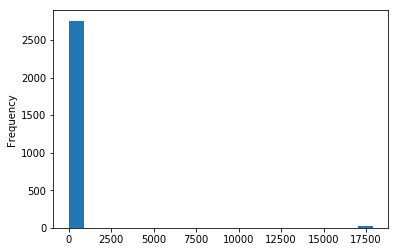

Firebird


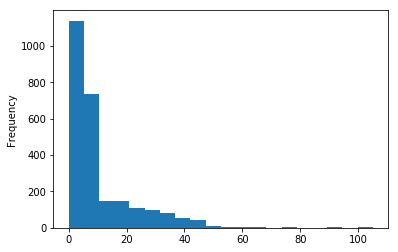

Impala


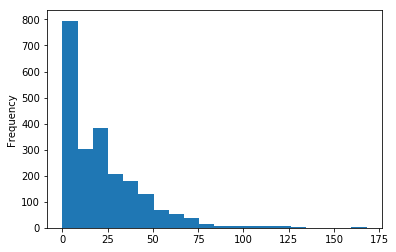

MonetDB


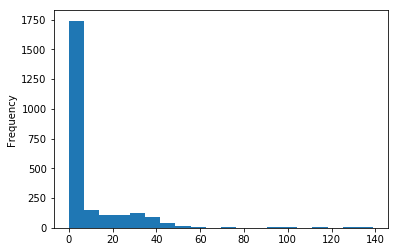

MS SQL Server


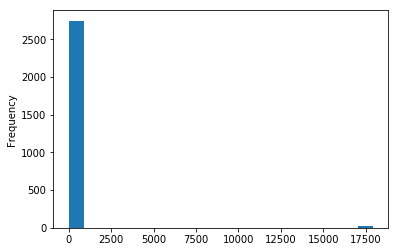

MariaDB


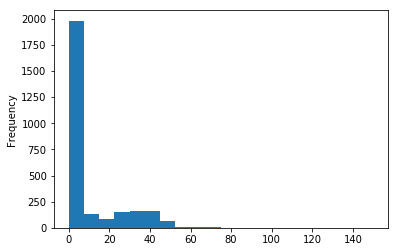

Oracle


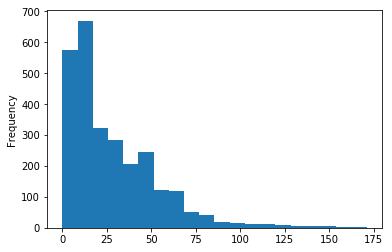

PostgreSQL


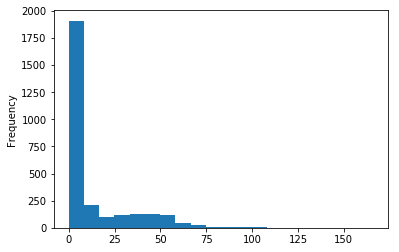

SQLite


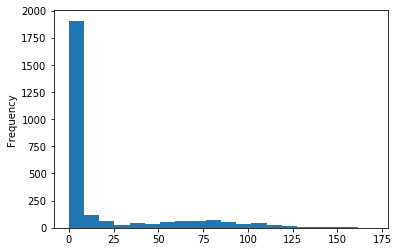

Teradata


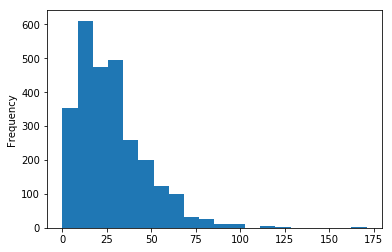

In [45]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
